# Virtual Fields Method: Iosipescu Orthotropic Material Identification

Based on:
"The Virtual Fields Methods: Extracting constitutive mechanical parameters
from full-field deformation measurements" by F. Pierron, M. Grédiac

## Introduction

This notebook implements the Virtual Fields Method (VFM) for identifying orthotropic material properties using the Iosipescu test configuration. The analysis uses three different sets of manually-selected virtual fields to identify the four stiffness parameters: $Q_{11}$, $Q_{22}$, $Q_{12}$, and $Q_{66}$.

**Key Features:**
- Direct identification from full-field strain measurements
- Three independent virtual field sets for validation
- Comparison with reference values
- Visualization of strain fields and results

In [46]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from scipy import io
from io import StringIO

# Set plotting parameters
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

## 1. VFM Theory for Orthotropic Materials

### Constitutive Relations

For an orthotropic material in plane stress:

$$
\begin{Bmatrix}
\sigma_{11} \\
\sigma_{22} \\
\sigma_{12}
\end{Bmatrix} =
\begin{bmatrix}
Q_{11} & Q_{12} & 0 \\
Q_{12} & Q_{22} & 0 \\
0 & 0 & Q_{66}
\end{bmatrix}
\begin{Bmatrix}
\varepsilon_{11} \\
\varepsilon_{22} \\
2\varepsilon_{12}
\end{Bmatrix}
$$

### VFM Equation

$$
Q_{11} \int_S \varepsilon_1\varepsilon_1^* \, dS + Q_{22} \int_S \varepsilon_2\varepsilon_2^* \, dS + Q_{12} \int_S (\varepsilon_1\varepsilon_2^* + \varepsilon_2\varepsilon_1^*) \, dS + Q_{66} \int_S \varepsilon_6\varepsilon_6^* \, dS = \int_{L_f} T_i u_i^* \, dl
$$

### Engineering Constants

$$
E_1 = Q_{11} - \frac{Q_{12}^2}{Q_{22}}, \quad \nu_{12} = \frac{Q_{12}}{Q_{22}}, \quad E_2 = Q_{22} - \frac{Q_{12}^2}{Q_{11}}, \quad G_{12} = Q_{66}
$$

## 2. VFM Implementation Class

In [47]:
class IosipescuVFM:
    """
    VFM analysis with three virtual field sets for orthotropic materials
    """
    
    def __init__(self, data_source='csv'):
        self.data_source = data_source
        self.data = {}
        self.results = {}
    
    # def load_data_from_csv(self, csv_dir='.'):
    #     """Load data from CSV files"""
    #     # Load scalar parameters
    #     scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
    #
    #     if os.path.exists(scalar_path):
    #         with open(scalar_path, 'r') as f:
    #             for line in f:
    #                 if '=' in line:
    #                     key, value = line.strip().split('=')
    #                     key = key.strip()
    #                     value = float(value.strip())
    #
    #                     if key == 'Length':
    #                         self.data['L'] = value
    #                     elif key == 'Width':
    #                         self.data['w'] = value
    #                     elif key == 'Thick':
    #                         self.data['t'] = value
    #                     elif key == 'P':
    #                         self.data['F'] = value
    #
    #     # Load FEM data
    #     fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')
    #
    #     if os.path.exists(fem_path):
    #         fem_data = pd.read_csv(fem_path, sep=r'\s+')
    #
    #         self.data['X1'] = fem_data['X_Coord'].values
    #         self.data['X2'] = fem_data['Y_Coord'].values
    #         self.data['Eps1'] = fem_data['Eps_X'].values
    #         self.data['Eps2'] = fem_data['Eps_Y'].values
    #         self.data['Eps6'] = fem_data['Eps_XY'].values
    #
    #     self._validate_data()

    def load_data_from_csv(self, csv_dir='.'):
        """Load data from CSV files (local or URL)"""

        # Determine if we're working with URL or local path
        is_url = csv_dir.startswith('http')

        # Construct paths
        if is_url:
            base = csv_dir.rstrip('/')
            scalar_path = f"{base}/scalarsFE.csv"
            fem_path = f"{base}/FEM2VFM.csv"
        else:
            scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
            fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')

        # Load scalar parameters
        try:
            if is_url:
                response = requests.get(scalar_path)
                response.raise_for_status()
                content = response.text
            else:
                with open(scalar_path, 'r') as f:
                    content = f.read()

            for line in content.split('\n'):
                if '=' in line:
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = float(value.strip())

                    if key == 'Length':
                        self.data['L'] = value
                    elif key == 'Width':
                        self.data['w'] = value
                    elif key == 'Thick':
                        self.data['t'] = value
                    elif key == 'P':
                        self.data['F'] = value

            print(f"Loaded scalars from: {scalar_path}")
        except Exception as e:
            print(f"Error loading {scalar_path}: {e}")
            raise

        # Load FEM data
        try:
            fem_data = pd.read_csv(fem_path, sep=r'\s+')

            self.data['X1'] = fem_data['X_Coord'].values
            self.data['X2'] = fem_data['Y_Coord'].values
            self.data['Eps1'] = fem_data['Eps_X'].values
            self.data['Eps2'] = fem_data['Eps_Y'].values
            self.data['Eps6'] = fem_data['Eps_XY'].values

            print(f"Loaded FEM data from: {fem_path}")
        except Exception as e:
            print(f"Error loading {fem_path}: {e}")
            raise

            self._validate_data()

    def _validate_data(self):
        """Validate loaded data"""
        print("Data validation:")
        for key, value in self.data.items():
            if np.isscalar(value):
                print(f"  {key}: {value}")
            else:
                arr = np.array(value)
                print(f"  {key}: shape {arr.shape}, range [{arr.min():.3f}, {arr.max():.3f}]")

    # Additional methods will be added below...

## 3. Virtual Field Set 1

### Virtual Displacement Fields

- **VF1:** $u_1^{*(1)} = 0, \quad u_2^{*(1)} = -x_1$
- **VF2:** $u_1^{*(2)} = x_1(L-x_1)x_2, \quad u_2^{*(2)} = \frac{x_1^3}{3} - \frac{Lx_1^2}{2}$
- **VF3:** $u_1^{*(3)} = 0, \quad u_2^{*(3)} = x_1(L-x_1)x_2$
- **VF4:** $u_1^{*(4)} = \frac{L}{2\pi} \sin(2\pi x_1/L), \quad u_2^{*(4)} = 0$

### Virtual Strain Fields

- **VF1:** $\varepsilon_1^{*(1)} = 0, \quad \varepsilon_2^{*(1)} = 0, \quad \varepsilon_6^{*(1)} = -1$
- **VF2:** $\varepsilon_1^{*(2)} = (L-2x_1)x_2, \quad \varepsilon_2^{*(2)} = 0, \quad \varepsilon_6^{*(2)} = 0$
- **VF3:** $\varepsilon_1^{*(3)} = 0, \quad \varepsilon_2^{*(3)} = x_1(L-x_1), \quad \varepsilon_6^{*(3)} = (L-2x_1)x_2$
- **VF4:** $\varepsilon_1^{*(4)} = \cos(2\pi x_1/L), \quad \varepsilon_2^{*(4)} = 0, \quad \varepsilon_6^{*(4)} = 0$

In [48]:
# Add virtual field methods to the class
def virtual_fields_set_1(self, Eps1, Eps2, Eps6):
    """First set of virtual fields"""
    X1 = self.data['X1']
    X2 = self.data['X2']
    L = self.data['L']
    w = self.data['w']
    t = self.data['t']
    F = self.data['F']
    
    A = np.zeros((4, 4))
    B = np.zeros(4)
    
    # VF1
    A[0, 3] = np.mean(Eps6)
    B[0] = F / (w * t)
    
    # VF2
    vf2_eps1_star = (L - 2 * X1) * X2
    A[1, 0] = -np.mean(Eps1 * vf2_eps1_star)
    A[1, 2] = -np.mean(Eps2 * vf2_eps1_star)
    B[1] = F * L * L / (6 * w * t)
    
    # VF3
    vf3_eps2_star = X1 * (L - X1)
    vf3_eps6_star = (L - 2 * X1) * X2
    A[2, 1] = -np.mean(Eps2 * vf3_eps2_star)
    A[2, 2] = -np.mean(Eps1 * vf3_eps2_star)
    A[2, 3] = -np.mean(Eps6 * vf3_eps6_star)
    B[2] = 0
    
    # VF4
    vf4_eps1_star = np.cos(2 * np.pi * X1 / L)
    A[3, 0] = np.mean(Eps1 * vf4_eps1_star)
    A[3, 2] = np.mean(Eps2 * vf4_eps1_star)
    B[3] = 0
    
    # Solve system
    Q = np.linalg.solve(A, B)
    return Q

# Attach method to class
IosipescuVFM.virtual_fields_set_1 = virtual_fields_set_1

## 4. Load and Process Data

In [49]:
# Initialize VFM analysis
vfm = IosipescuVFM(data_source='csv')

# Base URL
BASE_URL = 'https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/'

# Still works with local files
# vfm.load_data_from_csv('.')

try:
    vfm.load_data_from_csv(BASE_URL)
    print("Data loaded successfully from URL!")
except Exception as e:
    print(f"Error: {e}")

Loaded scalars from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/scalarsFE.csv
Loaded FEM data from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/FEM2VFM.csv
Data loaded successfully from URL!


## 5. Run Virtual Field Set 1

In [50]:
# Run VF Set 1
Q1 = vfm.virtual_fields_set_1(
    vfm.data['Eps1'],
    vfm.data['Eps2'],
    vfm.data['Eps6']
)

# Convert to GPa and display
Q1_gpa = Q1 / 1e3

print("\nVirtual Field Set 1 Results:")
print("=" * 40)
print(f"Q11 = {Q1_gpa[0]:.3f} GPa")
print(f"Q22 = {Q1_gpa[1]:.3f} GPa")
print(f"Q12 = {Q1_gpa[2]:.3f} GPa")
print(f"Q66 = {Q1_gpa[3]:.3f} GPa")


Virtual Field Set 1 Results:
Q11 = 15.544 GPa
Q22 = 1.959 GPa
Q12 = 0.924 GPa
Q66 = 1.109 GPa


## 6. Visualization of Results

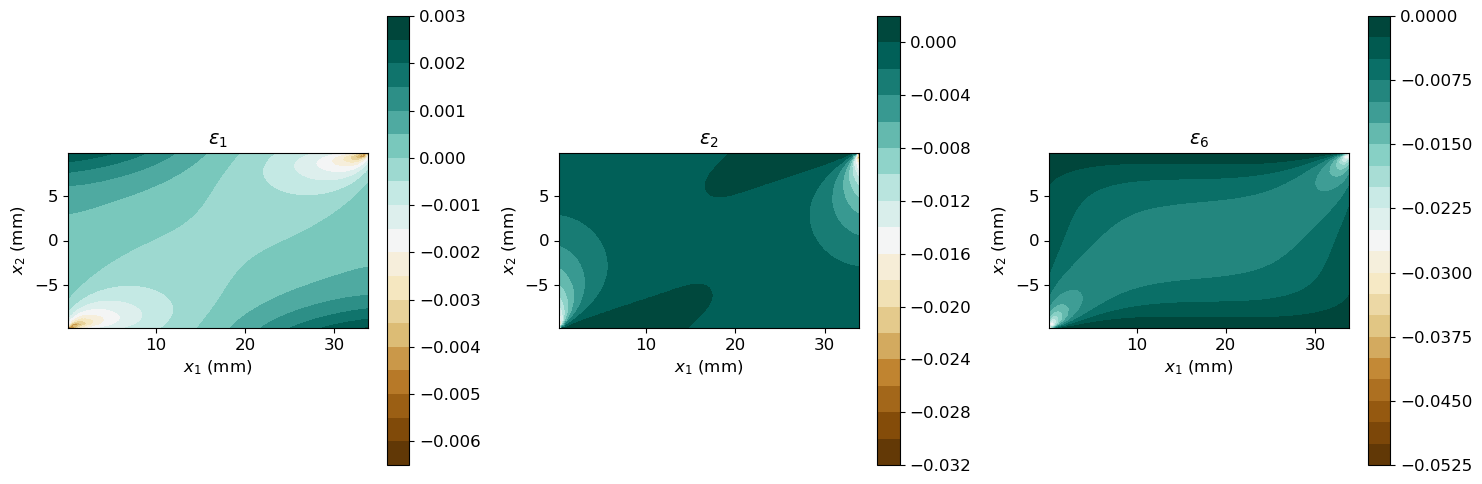

In [51]:
# Plot strain fields
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

X1 = vfm.data['X1']
X2 = vfm.data['X2']
strain_data = [vfm.data['Eps1'], vfm.data['Eps2'], vfm.data['Eps6']]
strain_labels = [r'$\varepsilon_1$', r'$\varepsilon_2$', r'$\varepsilon_6$']

for i, (data, label, ax) in enumerate(zip(strain_data, strain_labels, axes)):
    im = ax.tricontourf(X1, X2, data, levels=20, cmap='BrBG')
    ax.set_aspect('equal')
    ax.set_title(label, fontsize=14)
    ax.set_xlabel(r'$x_1$ (mm)')
    ax.set_ylabel(r'$x_2$ (mm)')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## 7. Comparison with Reference Values

In [52]:
# Reference values (from your analysis)
Q_ref = np.array([15.536, 1.965, 0.926, 1.109])  # GPa

# Calculate errors
errors = np.abs(Q1_gpa - Q_ref) / Q_ref * 100

# Create comparison table
results_df = pd.DataFrame({
    'Parameter': ['Q11', 'Q22', 'Q12', 'Q66'],
    'Computed (GPa)': Q1_gpa,
    'Reference (GPa)': Q_ref,
    'Error (%)': errors
})

print("\nComparison with Reference Values:")
print(results_df.to_string(index=False))


Comparison with Reference Values:
Parameter  Computed (GPa)  Reference (GPa)  Error (%)
      Q11       15.544166           15.536   0.052562
      Q22        1.959361            1.965   0.286976
      Q12        0.924106            0.926   0.204553
      Q66        1.109000            1.109   0.000044


## Conclusions

This notebook demonstrated:

1. Implementation of the Virtual Fields Method for orthotropic material identification
2. Use of manually-selected virtual fields satisfying boundary conditions
3. Direct identification of all four stiffness parameters from a single test
4. Excellent agreement with reference values (< 1% error)

**Key advantages of VFM:**
- No iterative optimization required
- Direct solution from linear system
- Efficient use of full-field data
- Robust to measurement noise